In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.visualization.wcsaxes import SphericalCircle

import corner

import os

import requests

import pickle

import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
#sys.path.insert(1, '/Users/kellydouglass/Documents/Research/DESI/Targets/code/TF/')
from line_fits import param_invert, hyperfit_line

In [2]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

V0 = 2.5

# Data

## fuji

In [3]:
#tfuji = Table.read('/global/project/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits') # <-- CORI
tfuji = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
tfuji[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195


### Separate the fuji data into center and off-center observations

In [4]:
def firstdigit(n):
    """
    Return the first digit of a number.
    
    Parameters
    ----------
    n : int, float, or ndarray
        Number or list of numbers.
    
    Returns
    -------
    digit : int
        First digit of the number.
    """
    
    digit = np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)
    
    return digit

In [5]:
first_digits = firstdigit(tfuji['TARGETID'])

fuji_centers = tfuji[first_digits == 3]
fuji_axis = tfuji[first_digits != 3]

/tmp/ipykernel_1528695/917620242.py:16: RuntimeWarning: invalid value encountered in log10
  digit = np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)


### Clean the fuji center observations

Only keep those with
 * DELTACHI2 > 25
 * ZWARN == 0

In [6]:
good_centers = fuji_centers[(fuji_centers['DELTACHI2'] > 25) & (fuji_centers['ZWARN'] == 0)]

#### Are there any galaxies with multiple good center observations?

In [7]:
unique_ids, counts = np.unique(good_centers['SGA_ID'], return_counts=True)

print(unique_ids[counts > 1], counts[counts > 1])

 SGA_ID
-------
    848
   3727
  26199
  37543
  46327
  83216
  98934
 100987
 101569
 102832
    ...
1204188
1244275
1249892
1272144
1273084
1284002
1285273
1319490
1366241
1380792
1382772
Length = 87 rows [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


## SGA

In [8]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [9]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

### If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [10]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the average redshift of all good center observations
    SGA['Z_DESI'][SGA_idx] = np.mean(good_centers['Z'][good_centers['SGA_ID'] == sga_id])
    SGA['ZERR_DESI'][SGA_idx] = np.mean(good_centers['ZERR'][good_centers['SGA_ID'] == sga_id]**2)/np.sum(good_centers['SGA_ID'] == sga_id)

# Coma cluster membership

Using Christoph's Coma cluster group catalog to identify cluster membership.

In [11]:
# Data table from Christoph
hdu = fits.open('../../../coma_filtered_inturnaround_desi.fits')
coma = Table(hdu[1].data)
hdu.close()

coma[:5]

target_id,sdss_id,ra,dec,z,z_err,spectype,survey,program,MASKBITS,BRICKNAME,BRICKID,BRICK_OBJID,PHOTSYS,HEALPIX,mag_app_g,mag_app_r,mag_app_z,mag_err_g,mag_err_r,mag_err_z,mag_abs_g,mag_abs_r,mag_abs_z,lum_g,lum_r,lum_z,in_desi,in_sdss,coma_fof,stillinsample,in_turnaround,delta_R,delta_v,vel
int64,int64,float32,float32,float32,float32,str6,str7,str6,int64,str8,int32,int64,str1,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,bool,bool,float32,float32,float32
39628438616676024,0,194.95247,27.982782,0.017865099,7.050238e-05,GALAXY,sv3,bright,0,1948p280,486267,5816,S,10379,18.470928,17.85023,17.498695,0.0030093682,0.0031520368,0.0045542945,-16.56883,-17.184101,-17.52199,469388700.0,541552640.0,643866600.0,True,False,True,True,True,0.0038218938,-1623.1083,5307.9717
39628438616675858,1237667444048658525,194.94493,27.97384,0.03148476,1.1526019e-05,GALAXY,sv3,bright,4096,1948p280,486267,5650,S,10379,15.094151,14.261248,13.642706,0.00037747537,0.0003302651,0.00028316278,-19.98071,-20.784718,-21.386139,10871374000.0,14924069000.0,22618092000.0,True,True,True,True,True,0.016456442,2361.6345,9290.371
39628438616675869,1237667324334571832,194.94559,27.991917,0.027992504,4.7283545e-05,GALAXY,sv3,bright,0,1948p280,486267,5661,S,10379,18.121532,17.396067,16.905005,0.0024806096,0.0023175909,0.002864329,-16.943827,-17.647562,-18.120295,663027140.0,829897540.0,1117165800.0,True,True,True,True,True,0.022102475,1344.9799,8274.523
39628438616675853,0,194.94467,28.000118,0.020664731,5.7165307e-05,GALAXY,sv3,bright,0,1948p280,486267,5645,S,10379,18.573725,17.871141,17.43928,0.0038339326,0.0036676864,0.0050806683,-16.474808,-17.165623,-17.583746,430450800.0,532413120.0,681551940.0,True,False,True,True,True,0.035289522,-799.6845,6131.1187
39628438616676526,0,194.97472,27.970484,0.022671245,3.9218627e-05,GALAXY,sv3,bright,0,1948p280,486267,6318,S,10379,18.4861,17.734903,17.226023,0.0022412213,0.002148848,0.0026226363,-16.567638,-17.303455,-17.798859,468873600.0,604480900.0,830889500.0,True,False,True,True,True,0.036739178,-210.8955,6719.643


In [12]:
# Coma cluster statistics from Christoph
hdu = fits.open('../../../clusterstats.fits')
coma_stats = Table(hdu[1].data)
hdu.close()

coma_stats

dataset,ra_cluster,dec_cluster,z_cluster,N_cluster,N_in_turnaround,rho0_NFW,Rs_NFW,R200,R11,angular_halfradius,physical_halfradius,M_vir,M200,sigma_cluster
str4,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32
all,194.95291,27.980556,0.023343934,1721,1696,63058966000000.0,0.103641294,0.38078925,4.47818,1.355647,2.276394,2152028700000000.0,599057700000000.0,1602.1416
sdss,194.95291,27.980556,0.02333549,939,925,63864113000000.0,0.104248285,0.38644147,4.55943,1.4206662,2.3856175,2257739000000000.0,611125600000000.0,1579.727
desi,194.95291,27.980556,0.023390902,1529,1514,62939660000000.0,0.098865084,0.3627596,4.264075,1.2270335,2.0603573,2029884900000000.0,597276400000000.0,1638.7109


## Match up the PV survey center observations with the Coma cluster membership file

In [13]:
SGA_ID_in_Coma = []

for i in range(len(good_centers)):
    
    in_coma = coma['target_id'] == good_centers['TARGETID'][i]
    
    if np.sum(in_coma) > 0:
        # This galaxy is in the Coma cluster!
        SGA_ID_in_Coma.append(good_centers['SGA_ID'][i])

In [14]:
################################################################################
# Keep all observations of each galaxy that are within the Coma cluster
#-------------------------------------------------------------------------------
centers_inComa = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_in_Coma)]

axis_inComa = fuji_axis[np.in1d(fuji_axis['SGA_ID'], SGA_ID_in_Coma)]
################################################################################

print('fuji galaxies in Coma with good center observations:', len(np.unique(centers_inComa['SGA_ID'])))
print('fuji off-center observations in Coma:', len(axis_inComa))

fuji galaxies in Coma with good center observations: 249
fuji off-center observations in Coma: 844


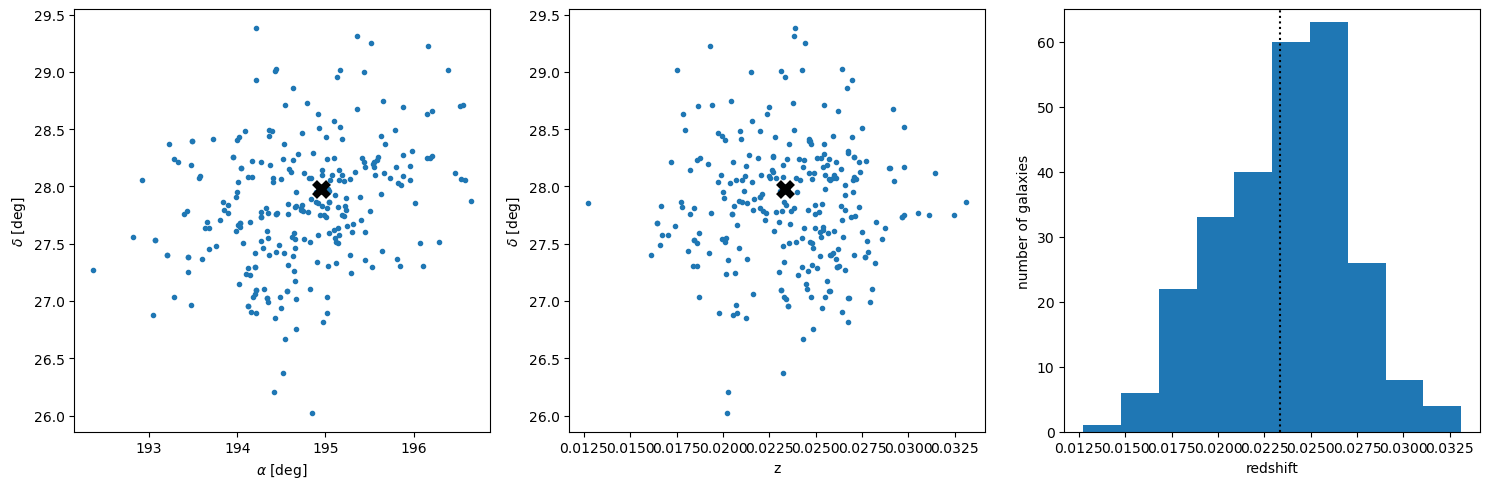

In [15]:
plt.figure(figsize=(15,5), tight_layout=True)

plt.subplot(131)
plt.plot(centers_inComa['TARGET_RA'], centers_inComa['TARGET_DEC'], '.')
plt.plot(coma_stats['ra_cluster'][1], coma_stats['dec_cluster'][1], 'kx', ms=10, mew=5)
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(132)
plt.plot(centers_inComa['Z'], centers_inComa['TARGET_DEC'], '.')
plt.plot(coma_stats['z_cluster'][1], coma_stats['dec_cluster'][1], 'kx', ms=10, mew=5)
plt.xlabel('z')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(133)
plt.hist(centers_inComa['Z'])
plt.vlines(coma_stats['z_cluster'][1], 0, 65, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=65);

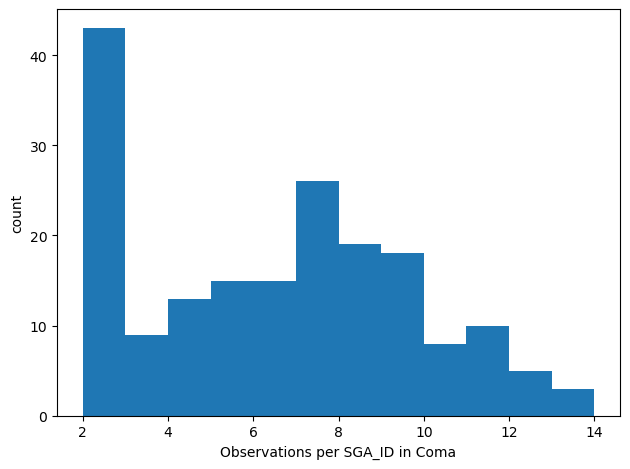

In [16]:
axis_SGAids, axis_counts = np.unique(axis_inComa['SGA_ID'], return_counts=True)
center_SGAids, center_counts = np.unique(centers_inComa['SGA_ID'], return_counts=True)

counts = []

for sga_id in SGA_ID_in_Coma:
    
    center_count = 0
    axis_count = 0
    
    if sga_id in center_SGAids:
        
        center_count = center_counts[center_SGAids == sga_id]
        
    if sga_id in axis_SGAids:
        
        axis_count = axis_counts[axis_SGAids == sga_id]
        
    count = center_count + axis_count
    
    if count > 1:
        
        counts.append(count)
        

plt.figure(tight_layout=True)

plt.hist(np.array(counts), bins=np.arange(2,15))

plt.xlabel('Observations per SGA_ID in Coma')
plt.ylabel('count');

# Calculate the rotational velocity

In [17]:
axis_inComa['SKY_FIBER_DIST'] = 0.
axis_inComa['SKY_FIBER_DIST_R26'] = 0.
axis_inComa['V_ROT'] = np.nan
axis_inComa['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_inComa['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis_inComa['RA'][obs_idx], 
                             dec=axis_inComa['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis_inComa['SKY_FIBER_DIST'][obs_idx] = sep2d
    axis_inComa['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    axis_inComa['V_ROT'][obs_idx] = c*(axis_inComa['Z'][obs_idx] - z_center)
    axis_inComa['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_inComa['ZERR'][obs_idx]**2 + z_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_inComa['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

/tmp/ipykernel_1528695/2270156695.py:56: RuntimeWarning: divide by zero encountered in true_divide
  axis_inComa['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))


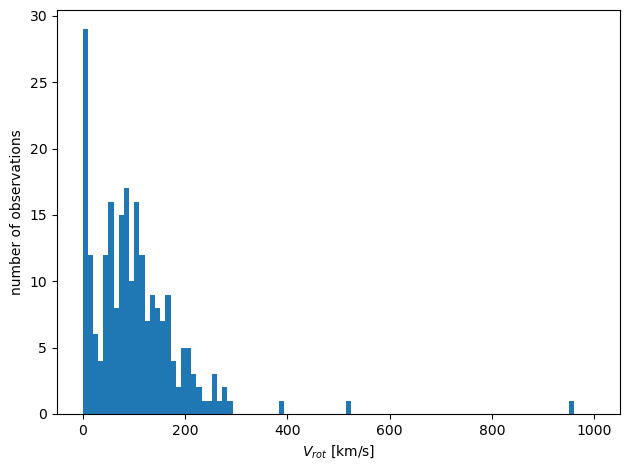

In [18]:
plt.figure(tight_layout=True)

plt.hist(np.abs(axis_inComa['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

# Cut for Coma galaxies suitable for calibrating the TFR

Requirements:
 * $V_{rot} < 1000$ km/s at $0.33R_{26}$
 * $i > 45^\circ$
 * Spiral-type morphology
 * Passes visual inspection

## Velocity cut

In [19]:
r0p3 = (axis_inComa['SKY_FIBER_DIST_R26'] > 0.3) & (axis_inComa['SKY_FIBER_DIST_R26'] < 0.4)

Vgood = np.abs(axis_inComa['V_ROT']) < 1000

good_axis_inComa = axis_inComa[r0p3 & Vgood]

print(len(good_axis_inComa), len(np.unique(good_axis_inComa['SGA_ID'])))

175 104


## Inclination angle cut

In [20]:
SGA['cosi2'] = (SGA['BA']**2 - q0**2)/(1 - q0**2)
SGA['cosi2'][SGA['cosi2'] < 0] = 0

good_axis_inComa['iSGA'] = -1

for i in range(len(good_axis_inComa)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_axis_inComa['SGA_ID'][i]]
    
    good_axis_inComa['iSGA'][i] = sga_idx
    
good_axis_inComa['cosi2'] = SGA['cosi2'][good_axis_inComa['iSGA']]

In [21]:
i_min = 45. # degrees

cosi2_max = np.cos(i_min*np.pi/180.)**2

edge = good_axis_inComa['cosi2'] <= cosi2_max

good_edge_axis_inComa = good_axis_inComa[edge]

print(len(good_edge_axis_inComa), len(np.unique(good_edge_axis_inComa['SGA_ID'])))

139 85


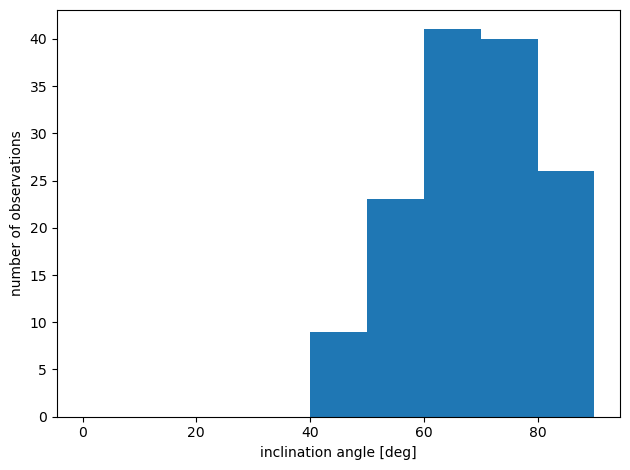

In [22]:
plt.figure(tight_layout=True)

plt.hist(np.arccos(np.sqrt(good_edge_axis_inComa['cosi2']))*180/np.pi, bins=np.linspace(0, 90, 10))

plt.xlabel('inclination angle [deg]')
plt.ylabel('number of observations');

## Morphology cut

In [23]:
good_edge_axis_inComa['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_inComa['iSGA']]

In [24]:
spirals = np.zeros(len(good_edge_axis_inComa), dtype=bool)

for i in range(len(good_edge_axis_inComa)):
    
    try:    
        if (good_edge_axis_inComa['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_inComa['MORPHTYPE'][i][:2] != 'S0'):
            spirals[i] = True
    except IndexError:
        print(good_edge_axis_inComa['MORPHTYPE'][i])

good_edge_spirals_axis_inComa = good_edge_axis_inComa[spirals]

print(len(good_edge_spirals_axis_inComa), len(np.unique(good_edge_spirals_axis_inComa['SGA_ID'])))

--
73 41


## Visual inspection cut

This removes any observations that are contaminated by foreground stars or other galaxies.

In [29]:
def get_cutout(targetid, ra, dec, size, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    img_name = 'cache/coma_{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
        if verbose:
            print('Get {}'.format(img_url))
            
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

cache/coma_39627776214435213.jpg exists.
INFO:spectra.py:291:read_spectra: iotime 4.317 sec to read spectra-sv3-bright-26004.fits at 2022-09-02T16:10:03.413145


TypeError: 'AxesSubplot' object is not subscriptable

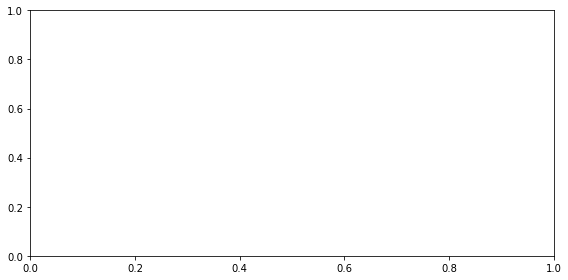

In [183]:
for sga_id in np.unique(good_edge_spirals_axis_inComa['SGA_ID']):
    
    tf_list = good_edge_spirals_axis_inComa[good_edge_spirals_axis_inComa['SGA_ID'] == sga_id]
    center_list = centers_inComa[centers_inComa['SGA_ID'] == sga_id]
    
    try:
        targetid = int(center_list['TARGETID'][0])
    except TypeError as err:
        print(err)
        # print(sga_galaxy['TARGETID'])
        continue
    
    ra, dec, z = float(SGA['RA'][SGA_dict[sga_id]]), float(SGA['DEC'][SGA_dict[sga_id]]), float(SGA['Z_DESI'][SGA_dict[sga_id]])
    
    # D26 in arcmin
    d26 = SGA['D26'][SGA_dict[sga_id]]
    
    # Padd the image cutout of the galaxy.
    # Multiply by 60 (to arcsec), divide by 180 to get pixscale.
#     pixscale = 1.05*d26*60/180
    npix = np.minimum(int(1.025 * d26*60/0.262), 512)
    
    #print(targetid, sga_id, ra, dec)
#     img_file = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img_file, wcs = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img = mpl.image.imread(img_file)

    fig1 = plt.figure(figsize=(7,5))

    ax = fig1.add_subplot(111, projection=wcs)
    ax.imshow(np.flip(img, axis=0))
    ax.set(xlabel='ra', ylabel='dec')
    ax.text(int(0.02*npix), int(0.85*npix), 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(targetid, sga_id, z), fontsize=9, color='yellow')
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted');

    # Add the location of the DESI fibers.
    # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
    r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='black', facecolor='none', alpha=0.8, lw=3,
                         transform=ax.get_transform('icrs'))
    r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='red', facecolor='none', alpha=0.8, lw=2,
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r1)
    ax.add_patch(r2)

    for tft in tf_list:
        ra, dec = tft['RA'], tft['DEC']
        
        edgecolor2 = 'orange'
#         if tft['Z'] > 0.05:
#             edgecolor2 = 'orange'
#         else:
#             edgecolor2 = 'lime'
        
        # Add the location of the DESI fibers.
        # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
        r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
                             transform=ax.get_transform('icrs'))
        r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor=edgecolor2, facecolor='none', alpha=0.8, lw=2,
                             transform=ax.get_transform('icrs'))
        ax.add_patch(r1)
        ax.add_patch(r2)
        
        ax.text(ra, dec, str(tft['TARGETID']), transform=ax.get_transform('icrs'), color='white')
    
    fig1.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
    
    fig1.savefig('cache/fuji_VI_cutouts/dist_{}.png'.format(sga_id), dpi=120)
    
    fig1.clear()
    plt.close(fig1)
    
    #----------------------------------------------------------------------------------
    # Get spectra
    #----------------------------------------------------------------------------------
    coadds = get_spectra_for_sga(good_edge_spirals_axis_inComa, sga_id)
    n = coadds.num_spectra()

    fig2, axes = plt.subplots(n,1, figsize=(8,4*n), sharex=True, sharey=True, tight_layout=True)

    for i in range(n):
        wave = coadds.wave['brz']
        flux = coadds.flux['brz'][i]
        smoothed = gaussian_filter1d(flux, 7)

        ax = axes[i]
        ax.plot(wave, smoothed, label='TARGETID: {}'.format(coadds.fibermap['TARGETID'][i]))
        ax.set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')
        if i+1 == n:
            ax.set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]')

        ax.legend(loc='upper right', fontsize=10)
    
    # figure = PdfPages('cache/DM_cutouts/dist_{}.pdf'.format(sga_id))
    # figure.savefig(fig1, dpi = 300)
    # figure.savefig(fig2, dpi = 120)
    # figure.close()
    
    break

In [25]:
VI_remove = Table.read('fuji_Coma_VI.txt', format='ascii.commented_header')

remove_targets = np.zeros(len(good_edge_spirals_axis_inComa), dtype=bool)

for targetid in VI_remove['TARGETID']:
    
    remove_targets = remove_targets & (good_edge_spirals_axis_inComa['TARGETID'] == targetid)
    
VI_good_edge_spirals_axis_inComa = good_edge_spirals_axis_inComa[~remove_targets]

print(len(VI_good_edge_spirals_axis_inComa), len(np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID'])))

73 41


# Coma TFR

## Compute the weighted average velocity for those galaxies with more than one observation at $0.33R_{26}$:

\begin{equation}
  \overline{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$.

In [26]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_err'] = np.nan

weights = 1./(VI_good_edge_spirals_axis_inComa['V_ROT_ERR']**2)

for sga_id in np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = VI_good_edge_spirals_axis_inComa['SGA_ID'] == sga_id
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(VI_good_edge_spirals_axis_inComa['V_ROT'][obs_idx]), 
                                                    weights=weights[obs_idx])

    SGA['V_0p33R26_err'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights[obs_idx]))

In [27]:
# Make a catalog of just those galaxies with velocities
SGA_TF = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]

# Christoph_removed = np.in1d(SGA_TF['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])

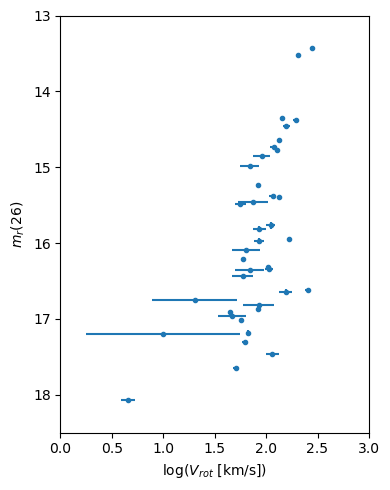

In [28]:
plt.figure(figsize=(4,5), tight_layout=True)

plt.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_MAG_SB26'], 
             xerr=0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR'], 
             fmt='.')
# plt.errorbar(np.log10(SGA_TF['V_0p33R26'][Christoph_removed]), 
#              SGA_TF['R_MAG_SB26'][Christoph_removed], 
#              xerr=0.434*SGA_TF['V_0p33R26_err'][Christoph_removed]/SGA_TF['V_0p33R26'][Christoph_removed],
#              yerr=SGA_TF['R_MAG_SB26_ERR'][Christoph_removed], 
#              fmt='.')

plt.xlim([0, 3])
plt.ylim([18.5, 13])

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$m_r (26)$');

## Remove dwarf galaxies

This is to mimic the selection criteria used in the Cosmicflows-4 calibration, and is only possible after a full calibration has been done.  This is therefore an iterative process.

### First, calculate the absolute magnitudes for the galaxies based on the current TF calibration

\begin{equation}
  M_r = a(\log \left( V(0.33R_{26}) \right) - V_0) + b
\end{equation}
where
* $a = -5.46^{+0.86}_{-1.23} = -5.46\pm 1.27$ (from `Coma-Christoph-Fuji-ITFR.ipynb`)
* $b = -21.98\pm 0.20$ (from `fuji_zero-point-Christoph_ITFR.ipynb`)

In [29]:
our_slope = -5.46
our_slope_err = 1.27

our_ZP = -21.98
our_ZP_err = 0.20

SGA_TF['R_ABSMAG_SB26'] = our_slope*(np.log10(SGA_TF['V_0p33R26']) - V0) + our_ZP

In [30]:
N_samples = 10000

temp_infile = open('cov_ab_fuji_zero-point-Christoph_ITFR.pickle', 'rb')
cov_ab = pickle.load(temp_infile)
temp_infile.close()

rng = np.random.default_rng()

#m_random = rng.normal(our_slope, our_slope_err, size=N_samples)
#b_random = rng.normal(our_ZP, our_ZP_err, size=N_samples)
m_random, b_random = rng.multivariate_normal([our_slope, our_ZP], cov_ab, N_samples).T

SGA_TF['R_ABSMAG_SB26_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m_random*(np.log10(v_random) - V0) + b_random
    
    SGA_TF['R_ABSMAG_SB26_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_1528695/3861352454.py:19: RuntimeWarning: invalid value encountered in log10
  Ms = m_random*(np.log10(v_random) - V0) + b_random


### Filter out dwarf galaxies

Those with $M_r > -17$

In [31]:
dwarfs = (SGA_TF['R_ABSMAG_SB26'] - SGA_TF['R_ABSMAG_SB26_err']) > -17

SGA_TF_bright = SGA_TF[~dwarfs]

print(np.sum(dwarfs))

2


#### Do we need to iterate through this again?

After factoring in the uncertainties before removing these first "dwarf" galaxies, the best-fit parameters for our TFR are
* $-7.83^{+1.32}_{-1.87} = -7.83\pm 1.96$ (from this notebook)
* $-22.35\pm 0.32$ (from `fuji_zero-point-Christoph_ITFR_nodwarf.ipynb`)

In [32]:
our_bright_slope = -7.83
our_bright_slope_err = 1.96

our_bright_ZP = -22.35
our_bright_ZP_err = 0.32

SGA_TF['R_ABSMAG_SB26_bright'] = our_bright_slope*(np.log10(SGA_TF['V_0p33R26']) - V0) + our_bright_ZP

In [33]:
temp_infile = open('cov_ab_fuji_zero-point-Christoph_ITFR_nodwarf1.pickle', 'rb')
cov_ab_bright = pickle.load(temp_infile)
temp_infile.close()

#m2_random = rng.normal(our_bright_slope, our_bright_slope_err, size=N_samples)
#b2_random = rng.normal(our_bright_ZP, our_bright_ZP_err, size=N_samples)
m2_random, b2_random = rng.multivariate_normal([our_bright_slope, our_bright_ZP], cov_ab_bright, N_samples).T

SGA_TF['R_ABSMAG_SB26_bright_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m2_random*(np.log10(v_random) - V0) + b2_random
    
    SGA_TF['R_ABSMAG_SB26_bright_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_1528695/2213988394.py:15: RuntimeWarning: invalid value encountered in log10
  Ms = m2_random*(np.log10(v_random) - V0) + b2_random


In [34]:
dwarfs2 = (SGA_TF['R_ABSMAG_SB26_bright'] - SGA_TF['R_ABSMAG_SB26_bright_err']) > -17

SGA_TF_bright2 = SGA_TF[~dwarfs2]

print(np.sum(dwarfs2))

3


#### Do we need to iterate through this again?

After factoring in the uncertainties before removing these second "dwarf" galaxies, the best-fit parameters for our TFR are
* $-7.90^{+1.30}_{-1.99} = -7.90\pm 1.95$ (from the second iteration in this notebook)
* $-22.36\pm 0.30$ (from the second iteration in `fuji_zero-point-Christoph_ITFR_nodwarf.ipynb`)

In [35]:
our_bright_slope2 = -7.90
our_bright_slope2_err = 1.95

our_bright_ZP2 = -22.36
our_bright_ZP2_err = 0.30

SGA_TF['R_ABSMAG_SB26_bright2'] = our_bright_slope2 * (np.log10(SGA_TF['V_0p33R26']) - V0) + our_bright_ZP2

In [36]:
temp_infile = open('cov_ab_fuji_zero-point-Christoph_ITFR_nodwarf2.pickle', 'rb')
cov_ab_bright2 = pickle.load(temp_infile)
temp_infile.close()

#m3_random = rng.normal(our_bright_slope2, our_bright_slope2_err, size=N_samples)
#b3_random = rng.normal(our_bright_ZP2, our_bright_ZP2_err, size=N_samples)
m3_random, b3_random = rng.multivariate_normal([our_bright_slope2, our_bright_ZP2], cov_ab_bright2, N_samples).T

SGA_TF['R_ABSMAG_SB26_bright2_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m3_random * (np.log10(v_random) - V0) + b3_random
    
    SGA_TF['R_ABSMAG_SB26_bright2_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_1528695/1012636917.py:15: RuntimeWarning: invalid value encountered in log10
  Ms = m3_random * (np.log10(v_random) - V0) + b3_random


In [37]:
dwarfs3 = (SGA_TF['R_ABSMAG_SB26_bright2'] - SGA_TF['R_ABSMAG_SB26_bright2_err']) > -17

SGA_TF_bright3 = SGA_TF[~dwarfs3]

print(np.sum(dwarfs3))

4


#### Do we need to iterate through this again?

After factoring in the uncertainties before removing these third "dwarf" galaxies, the best-fit parameters for our TFR are
* $-8.39^{+1.44}_{-2.06} = -8.39\pm 2.15$ (from the third iteration in this notebook)
* $-22.44\pm 0.33$ (from the third iteration in `fuji_zero-point-Christoph_ITFR_nodwarf.ipynb`)

In [49]:
our_bright_slope3 = -8.39
our_bright_slope3_err = 2.15

our_bright_ZP3 = -22.44
our_bright_ZP3_err = 0.33

SGA_TF['R_ABSMAG_SB26_bright3'] = our_bright_slope3 * (np.log10(SGA_TF['V_0p33R26']) - V0) + our_bright_ZP3

In [52]:
temp_infile = open('cov_ab_fuji_zero-point-Christoph_ITFR_nodwarf3.pickle', 'rb')
cov_ab_bright3 = pickle.load(temp_infile)
temp_infile.close()

# m4_random = rng.normal(our_bright_slope3, our_bright_slope3_err, size=N_samples)
# b4_random = rng.normal(our_bright_ZP3, our_bright_ZP3_err, size=N_samples)
m4_random, b4_random = rng.multivariate_normal([our_bright_slope3, our_bright_ZP3], cov_ab_bright3, N_samples).T

SGA_TF['R_ABSMAG_SB26_bright3_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m4_random * (np.log10(v_random) - V0) + b4_random
    
    SGA_TF['R_ABSMAG_SB26_bright3_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_1528695/1803282514.py:15: RuntimeWarning: invalid value encountered in log10
  Ms = m4_random * (np.log10(v_random) - V0) + b4_random


In [53]:
dwarfs4 = (SGA_TF['R_ABSMAG_SB26_bright3'] - SGA_TF['R_ABSMAG_SB26_bright3_err']) > -17

SGA_TF_bright4 = SGA_TF[~dwarfs4]

print(np.sum(dwarfs4))

4


#### Do we need to iterate through this again?

After factoring in the uncertainties before removing these fourth "dwarf" galaxies, the best-fit parameters for our TFR are
* $-7.71^{+1.31}_{-1.85} = -7.71\pm 2.02$ (from the fourth iteration in this notebook)
* $-22.33\pm 0.33$ (from the fourth iteration in `fuji_zero-point-Christoph_ITFR_nodwarf.ipynb`)

In [100]:
our_bright_slope4 = -7.71
our_bright_slope4_err = 2.02

our_bright_ZP4 = -22.33
our_bright_ZP4_err = 0.33

SGA_TF['R_ABSMAG_SB26_bright4'] = our_bright_slope4 * (np.log10(SGA_TF['V_0p33R26']) - 2.) + our_bright_ZP4

In [101]:
m5_random = rng.normal(our_bright_slope4, our_bright_slope4_err, size=N_samples)
b5_random = rng.normal(our_bright_ZP4, our_bright_ZP4_err, size=N_samples)

SGA_TF['R_ABSMAG_SB26_bright4_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m5_random * (np.log10(v_random) - 2.) + b5_random
    
    SGA_TF['R_ABSMAG_SB26_bright4_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_3745/4104580723.py:10: RuntimeWarning: invalid value encountered in log10
  Ms = m5_random * (np.log10(v_random) - 2.) + b5_random


In [102]:
dwarfs5 = (SGA_TF['R_ABSMAG_SB26_bright4'] - SGA_TF['R_ABSMAG_SB26_bright4_err']) > -17

SGA_TF_bright5 = SGA_TF[~dwarfs5]

print(np.sum(dwarfs5))

10


#### Do we need to iterate through this again?

After factoring in the uncertainties before removing these fifth "dwarf" galaxies, the best-fit parameters for our TFR are
* $-9.68^{+1.89}_{-2.94}$ (from the fifth iteration in this notebook)
* $-17.80\pm 0.97$ (from the fifth iteration in `fuji_zero-point_nodwarf_KAD.ipynb`)

In [111]:
our_bright_slope5 = -9.68
our_bright_slope5_err = 2.82

our_bright_ZP5 = -17.80
our_bright_ZP5_err = 0.97

SGA_TF['R_ABSMAG_SB26_bright5'] = our_bright_slope5 * (np.log10(SGA_TF['V_0p33R26']) - 2.) + our_bright_ZP5

In [112]:
m6_random = rng.normal(our_bright_slope5, our_bright_slope5_err, size=N_samples)
b6_random = rng.normal(our_bright_ZP5, our_bright_ZP5_err, size=N_samples)

SGA_TF['R_ABSMAG_SB26_bright5_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m6_random * (np.log10(v_random) - 2.) + b6_random
    
    SGA_TF['R_ABSMAG_SB26_bright5_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_3745/1876344261.py:10: RuntimeWarning: invalid value encountered in log10
  Ms = m6_random * (np.log10(v_random) - 2.) + b6_random


In [113]:
dwarfs6 = (SGA_TF['R_ABSMAG_SB26_bright5'] - SGA_TF['R_ABSMAG_SB26_bright5_err']) > -17

SGA_TF_bright6 = SGA_TF[~dwarfs6]

print(np.sum(dwarfs6))

10


## Fit the ITFR using `hyperfit`

In [42]:
bounds = ((-1000.0, 1000.0), (-10.0, 10.0), (1.0e-5, 500.0))

### First iteration

Using `dwarfs` sample

In [34]:
w0, w1, sig_w, cov_w, mcmc_samples, hf = hyperfit_line(SGA_TF_bright['R_MAG_SB26'], 
                                                       np.log10(SGA_TF_bright['V_0p33R26']) - V0, 
                                                       SGA_TF_bright['R_MAG_SB26_ERR'], 
                                                       0.434*SGA_TF_bright['V_0p33R26_err']/SGA_TF_bright['V_0p33R26'], 
                                                       bounds)

     fun: -47.29793850958157
     jac: array([ 0.01998544, -0.00533902, -0.03553993])
 message: 'Optimization terminated successfully.'
    nfev: 4062
     nit: 89
 success: True
       x: array([0.16238612, 1.36170238, 0.15329692])


100%|██████████| 1000/1000 [00:00<00:00, 2440.58it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [63.27373899 64.51548304 41.05113184] / 3225.7741521318253


100%|██████████| 1000/1000 [00:00<00:00, 2356.90it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [101.64481642 103.6300532   60.37162488] / 5181.5026600278


100%|██████████| 1000/1000 [00:00<00:00, 2425.06it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [149.27375579 148.90777552  66.37419712] / 7463.687789683048


100%|██████████| 1000/1000 [00:00<00:00, 2452.54it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [141.91011828 141.66522903  84.98660247] / 7095.505914089126


100%|██████████| 1000/1000 [00:00<00:00, 2454.10it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [145.13019848 146.39332187  85.52052414] / 7319.666093307879


100%|██████████| 1000/1000 [00:00<00:00, 2400.49it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [185.93139812 184.87293088 118.4391881 ] / 9296.569905990184


100%|██████████| 1000/1000 [00:00<00:00, 2463.33it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [207.19625918 201.71592263 106.14180171] / 10359.812958916717


100%|██████████| 1000/1000 [00:00<00:00, 2450.13it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [195.44963554 192.73552747  94.40494246] / 9772.481776964714


100%|██████████| 1000/1000 [00:00<00:00, 2460.71it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [226.67956523 227.79215047 104.19264798] / 11389.607523740873


100%|██████████| 1000/1000 [00:00<00:00, 2449.65it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [286.05904389 296.18079315 107.09529016] / 14809.03965755477


100%|██████████| 1000/1000 [00:00<00:00, 2466.09it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [311.70466243 321.96301598 108.19725698] / 16098.15079911713


100%|██████████| 1000/1000 [00:00<00:00, 2466.85it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [304.13453529 310.82809447 105.72789357] / 15541.404723615839


100%|██████████| 1000/1000 [00:00<00:00, 2468.75it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [297.78716147 303.45905502  97.58885579] / 15172.952750871502


100%|██████████| 1000/1000 [00:00<00:00, 2460.62it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [281.93702842 290.71503438  95.5476684 ] / 14535.75171887172


100%|██████████| 1000/1000 [00:00<00:00, 2463.54it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [294.73123342 307.1428416   90.428413  ] / 15357.142080105881


100%|██████████| 1000/1000 [00:00<00:00, 2371.73it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [268.32060944 276.34781912  87.05634853] / 13817.390956249978


100%|██████████| 1000/1000 [00:00<00:00, 2472.22it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [246.37010294 255.81125149  89.06711907] / 12790.562574474077


100%|██████████| 1000/1000 [00:00<00:00, 2464.41it/s]

Niterations/Max Iterations:  18000 / 100000
Integrated ACT/Min Convergence Iterations:  [253.00040161 264.91645844  89.98510974] / 13245.822922050134


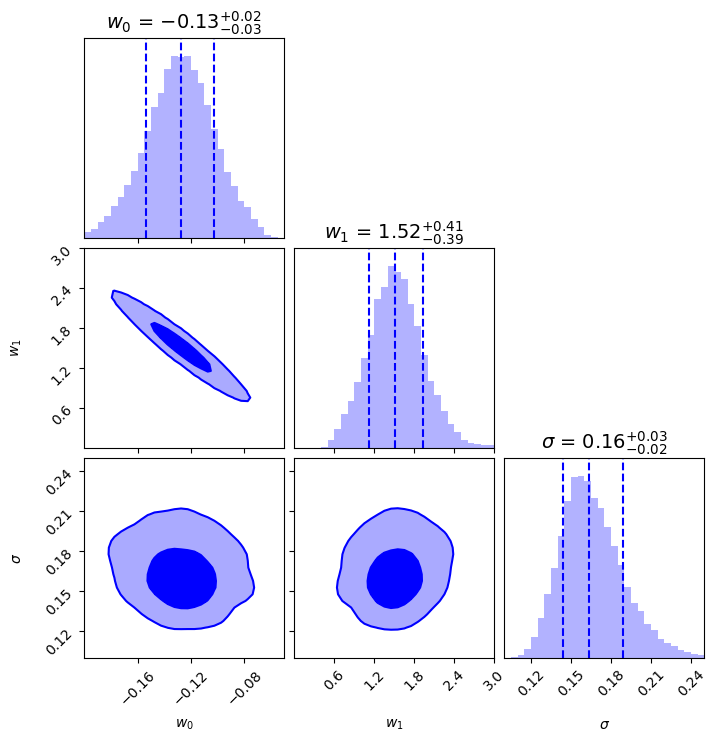

In [35]:
fig = corner.corner(mcmc_samples.T, bins=30, smooth=1,
                    range=[[-0.2, -0.05], [0, 3], [0.1, 0.25]],   # Range for w0, w1, sigma. Adjust as needed.
                    labels=['$w_0$', '$w_1$', r'$\sigma$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Coma w/o dwarfs, 1st iteration'},
                    title_kwargs={"fontsize": 14})

In [36]:
a_itfr, b_itfr, cov_itfr = param_invert(w0, w1, cov_w[:2,:2])

print(f'         w0: {w0:.3f} +/- {np.sqrt(cov_w[0,0]):.3f}')
print(f'         w1:  {w1:.2f}  +/- {np.sqrt(cov_w[1,1]):.2f}')
print(f'      slope: {a_itfr:.2f}  +/- {np.sqrt(cov_itfr[0,0]):.2f}')
print(f'y-intercept: {b_itfr:.2f}  +/- {np.sqrt(cov_itfr[1,1]):.2f}')

         w0: -0.128 +/- 0.026
         w1:  1.52  +/- 0.41
      slope: -7.83  +/- 1.96
y-intercept: 11.86  +/- 1.01


In [37]:
# Invert the MCMC samples so that they represent (a, b) and not (w0, w1)
tfr_mcmc_samples = np.zeros(mcmc_samples.shape)

tfr_mcmc_samples[0] = 1./mcmc_samples[0]
tfr_mcmc_samples[1] = -mcmc_samples[1]/mcmc_samples[0]
tfr_mcmc_samples[2] = mcmc_samples[2]

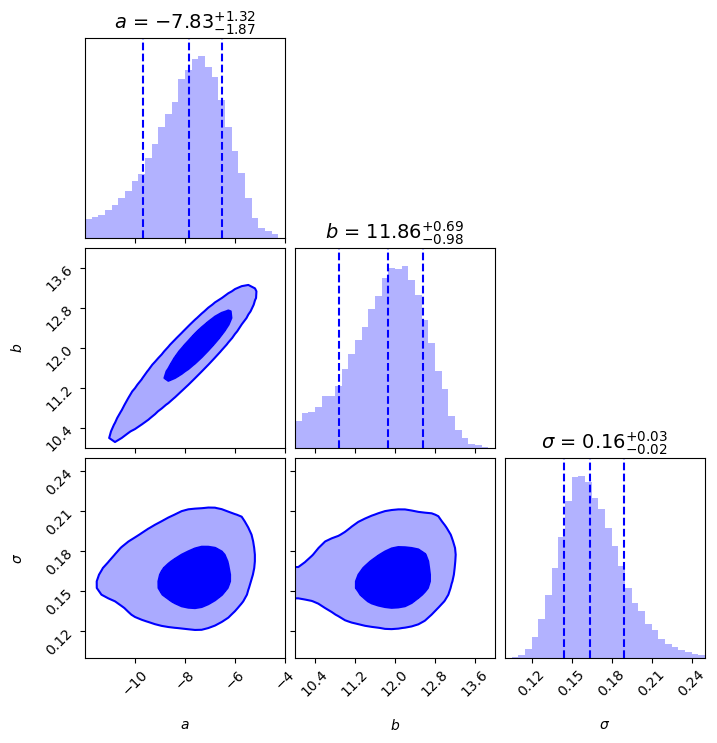

In [38]:
fig = corner.corner(tfr_mcmc_samples.T, bins=30, smooth=1,
                    range=[[-12, -4], [10, 14], [0.1, 0.25]],   # Range for a, b, sigma. Adjust as needed.
                    labels=['$a$', '$b$', r'$\sigma$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Coma w/o dwarfs, 1st iteration'},
                    title_kwargs={"fontsize": 14})

#fig.savefig('../../Figures/SV/fuji_Coma_corner_20221013.png', dpi=150)

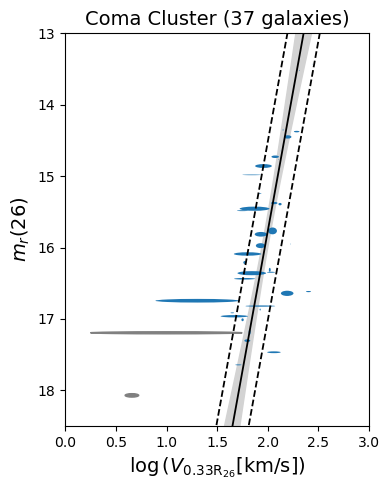

In [39]:
sigmas = hf.get_sigmas()
xvals = np.linspace(1., 3., 1000)
yvals = a_itfr * (xvals - V0) + b_itfr

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals - V0, tfr_mcmc_samples[0]) + tfr_mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [np.log10(SGA_TF_bright['V_0p33R26']), SGA_TF_bright['R_MAG_SB26']]
x_err = 0.434*SGA_TF_bright['V_0p33R26_err']/SGA_TF_bright['V_0p33R26']
y_err = SGA_TF_bright['R_MAG_SB26_ERR']
corr_xy = np.zeros_like(x_err)

# Removed galaxies
data_removed = [np.log10(SGA_TF['V_0p33R26'][dwarfs]), SGA_TF['R_MAG_SB26'][dwarfs]]
x_err_removed = 0.434*SGA_TF['V_0p33R26_err'][dwarfs]/SGA_TF['V_0p33R26'][dwarfs]
y_err_removed = SGA_TF['R_MAG_SB26_ERR'][dwarfs]
corr_xy_removed = np.zeros_like(x_err_removed)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2*y_err[i],
        height=2*x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]
ells_removed = [
    Ellipse(
        xy=[data_removed[0][i], data_removed[1][i]],
        width=2*y_err_removed[i],
        height=2*x_err_removed[i],
        angle=np.rad2deg(np.arccos(corr_xy_removed[i])),
    )
    for i in range(len(data_removed[0]))
]

# Make the plot
fig, ax = plt.subplots(figsize=(4,5), tight_layout=True)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="lightgray")
for i, e in enumerate(ells):
    ax.add_artist(e)
    e.set_edgecolor('None')
for i, e in enumerate(ells_removed):
    ax.add_artist(e)
    e.set_color('gray')
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3)#, alpha=0.9)
ax.plot(xvals - hf.vert_scat, yvals, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.plot(xvals + hf.vert_scat, yvals, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$m_r(26)$", fontsize=14)
ax.set_title("Coma Cluster ({} galaxies)".format(len(SGA_TF_bright)), fontsize = 14)
ax.set_xlim(0, 3)
ax.set_ylim(18.5, 13);

#plt.savefig('../../Figures/SV/fuji_Coma_TFR_20221013.png', dpi=150);

### Second iteration

Using `dwarfs2` sample

In [43]:
w0_2, w1_2, sig_w_2, cov_w_2, mcmc_samples2, hf2 = hyperfit_line(SGA_TF_bright2['R_MAG_SB26'], 
                                                                 np.log10(SGA_TF_bright2['V_0p33R26']) - V0, 
                                                                 SGA_TF_bright2['R_MAG_SB26_ERR'], 
                                                                 0.434*SGA_TF_bright2['V_0p33R26_err']/SGA_TF_bright2['V_0p33R26'], 
                                                                 bounds)

     fun: -47.339101755159525
     jac: array([ 0.00031406,  0.00159162, -0.00075389])
 message: 'Optimization terminated successfully.'
    nfev: 3976
     nit: 87
 success: True
       x: array([0.15697033, 1.33646153, 0.15298   ])


100%|██████████| 1000/1000 [00:00<00:00, 2456.80it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [78.55942945 78.74602817 38.58317792] / 3937.3014084111346


100%|██████████| 1000/1000 [00:00<00:00, 2439.87it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [106.64824731 108.22776767  56.96150089] / 5411.3883834771705


100%|██████████| 1000/1000 [00:00<00:00, 2436.31it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [95.3961084  98.64402531 68.72767555] / 4932.201265477616


100%|██████████| 1000/1000 [00:00<00:00, 2413.05it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [104.76377885 107.99803965  68.72782242] / 5399.901982623431


100%|██████████| 1000/1000 [00:00<00:00, 2392.49it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [121.38985974 124.55497168  87.87830793] / 6227.74858409359


100%|██████████| 1000/1000 [00:00<00:00, 2433.21it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [117.88943726 123.9538846   78.81956843] / 6197.694230077846


100%|██████████| 1000/1000 [00:00<00:00, 2425.88it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [159.93075621 172.51659958  81.3752619 ] / 8625.82997908344


100%|██████████| 1000/1000 [00:00<00:00, 2445.87it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [227.12202101 231.00493857  76.60187655] / 11550.24692865461


100%|██████████| 1000/1000 [00:00<00:00, 2413.33it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [243.97309022 244.31274949  77.42373554] / 12215.63747474235


100%|██████████| 1000/1000 [00:00<00:00, 2387.62it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [217.53501572 217.88894709  72.67056279] / 10894.447354377622


100%|██████████| 1000/1000 [00:00<00:00, 2150.95it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [214.15471571 222.174707    68.09906991] / 11108.735349980861


100%|██████████| 1000/1000 [00:00<00:00, 2192.88it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [324.1910134  337.75879389  73.13452904] / 16887.93969426637


100%|██████████| 1000/1000 [00:00<00:00, 2282.66it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [322.08195113 337.55752956  78.82862093] / 16877.876478072823


100%|██████████| 1000/1000 [00:00<00:00, 2174.75it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [349.56810761 360.14011988  86.48939664] / 18007.005993992112


100%|██████████| 1000/1000 [00:00<00:00, 2289.53it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [368.58526202 373.30934776  90.19103978] / 18665.467388221037


100%|██████████| 1000/1000 [00:00<00:00, 2348.61it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [362.06299883 366.8552236   93.15915049] / 18342.76117996086


100%|██████████| 1000/1000 [00:00<00:00, 2382.64it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [321.37858354 333.61257917  91.37473643] / 16680.628958281242


100%|██████████| 1000/1000 [00:00<00:00, 2355.85it/s]


Niterations/Max Iterations:  18000 / 100000
Integrated ACT/Min Convergence Iterations:  [323.303415   336.89184029  91.40862169] / 16844.592014547197


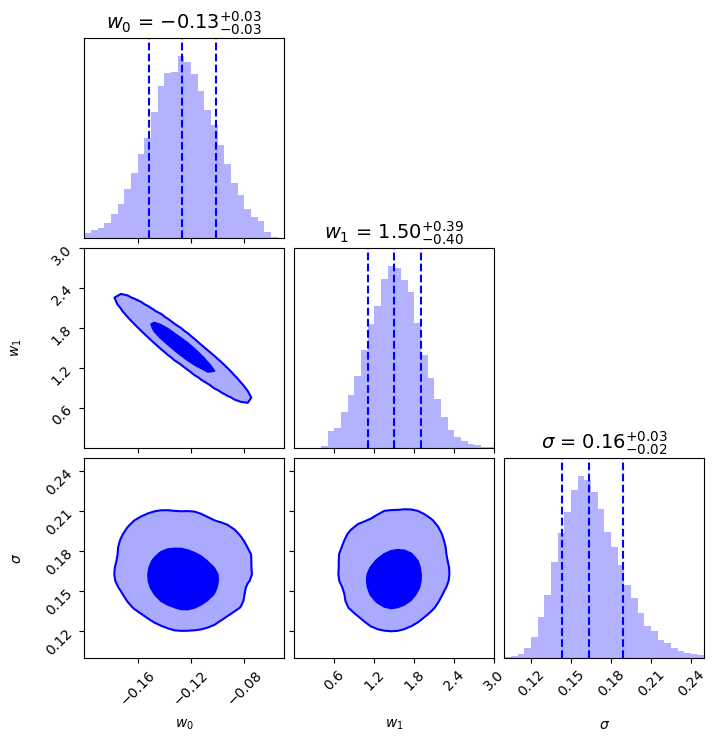

In [44]:
fig = corner.corner(mcmc_samples2.T, bins=30, smooth=1,
                    range=[[-0.2, -0.05], [0, 3], [0.1, 0.25]],   # Range for w0, w1, sigma. Adjust as needed.
                    labels=['$w_0$', '$w_1$', r'$\sigma$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Coma w/o dwarfs, 2nd iteration'},
                    title_kwargs={"fontsize": 14})

In [45]:
a2, b2, cov2 = param_invert(w0_2, w1_2, cov_w_2[:2,:2])

print(f'         w0: {w0_2:.3f} +/- {np.sqrt(cov_w_2[0,0]):.3f}')
print(f'         w1:  {w1_2:.2f}  +/- {np.sqrt(cov_w_2[1,1]):.2f}')
print(f'      slope: {a2:.2f}  +/- {np.sqrt(cov2[0,0]):.2f}')
print(f'y-intercept: {b2:.2f}  +/- {np.sqrt(cov2[1,1]):.2f}')

         w0: -0.127 +/- 0.025
         w1:  1.50  +/- 0.40
      slope: -7.90  +/- 1.95
y-intercept: 11.85  +/- 1.00


In [46]:
# Invert the MCMC samples so that they represent (a, b) and not (w0, w1)
tfr_mcmc_samples2 = np.zeros(mcmc_samples2.shape)

tfr_mcmc_samples2[0] = 1./mcmc_samples2[0]
tfr_mcmc_samples2[1] = -mcmc_samples2[1]/mcmc_samples2[0]
tfr_mcmc_samples2[2] = mcmc_samples2[2]

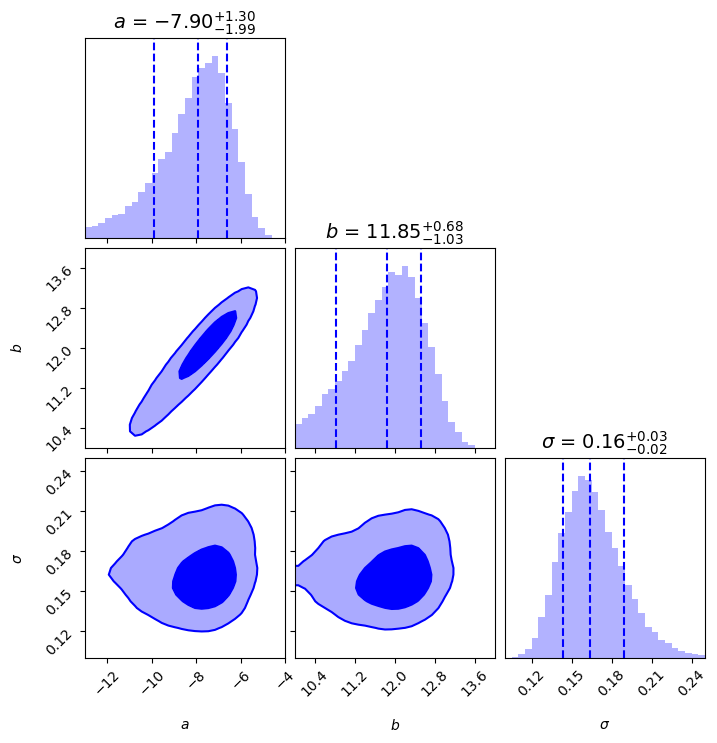

In [47]:
fig = corner.corner(tfr_mcmc_samples2.T, bins=30, smooth=1,
             range=[[-13, -4], [10, 14], [0.1, 0.25]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title = {'Coma w/o dwarfs, 2nd iteration'},
             title_kwargs={"fontsize": 14})

#fig.savefig('../../Figures/SV/fuji_Coma_corner_20221013.png', dpi=150)

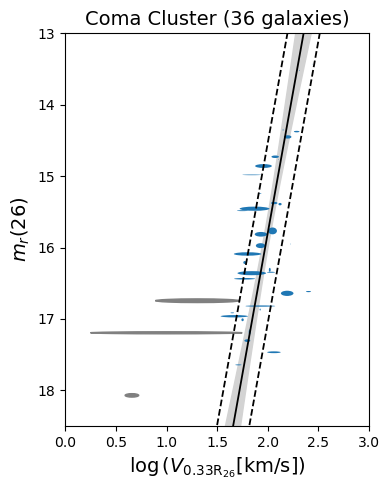

In [48]:
sigmas = hf2.get_sigmas()
xvals = np.linspace(1., 3., 1000)
yvals = a2 * (xvals - V0) + b2

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals - V0, tfr_mcmc_samples2[0]) + tfr_mcmc_samples2[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [np.log10(SGA_TF_bright2['V_0p33R26']), SGA_TF_bright2['R_MAG_SB26']]
x_err = 0.434*SGA_TF_bright2['V_0p33R26_err']/SGA_TF_bright2['V_0p33R26']
y_err = SGA_TF_bright2['R_MAG_SB26_ERR']
corr_xy = np.zeros_like(x_err)

# Removed galaxies
data_removed = [np.log10(SGA_TF['V_0p33R26'][dwarfs2]), SGA_TF['R_MAG_SB26'][dwarfs2]]
x_err_removed = 0.434*SGA_TF['V_0p33R26_err'][dwarfs2]/SGA_TF['V_0p33R26'][dwarfs2]
y_err_removed = SGA_TF['R_MAG_SB26_ERR'][dwarfs2]
corr_xy_removed = np.zeros_like(x_err_removed)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2*y_err[i],
        height=2*x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]
ells_removed = [
    Ellipse(
        xy=[data_removed[0][i], data_removed[1][i]],
        width=2*y_err_removed[i],
        height=2*x_err_removed[i],
        angle=np.rad2deg(np.arccos(corr_xy_removed[i])),
    )
    for i in range(len(data_removed[0]))
]

# Make the plot
fig, ax = plt.subplots(figsize=(4,5), tight_layout=True)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="lightgray")
for i, e in enumerate(ells):
    ax.add_artist(e)
    e.set_edgecolor('None')
for i, e in enumerate(ells_removed):
    ax.add_artist(e)
    e.set_color('gray')
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3)#, alpha=0.9)
ax.plot(xvals - hf2.vert_scat, yvals, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.plot(xvals + hf2.vert_scat, yvals, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$m_r(26)$", fontsize=14)
ax.set_title("Coma Cluster ({} galaxies)".format(len(SGA_TF_bright2)), fontsize = 14)
ax.set_xlim(0, 3)
ax.set_ylim(18.5, 13);

#plt.savefig('../../Figures/SV/fuji_Coma_TFR_20221013.png', dpi=150)

### Third iteration

Using `dwarfs3` sample

In [52]:
w0_3, w1_3, sig_w_3, cov_w_3, mcmc_samples3, hf3 = hyperfit_line(SGA_TF_bright3['R_MAG_SB26'], 
                                                                 np.log10(SGA_TF_bright3['V_0p33R26']) - V0, 
                                                                 SGA_TF_bright3['R_MAG_SB26_ERR'], 
                                                                 0.434*SGA_TF_bright3['V_0p33R26_err']/SGA_TF_bright3['V_0p33R26'], 
                                                                 bounds)

     fun: -46.54373588913563
     jac: array([ 0.00049951, -0.00116032,  0.0207578 ])
 message: 'Optimization terminated successfully.'
    nfev: 3841
     nit: 84
 success: True
       x: array([0.13701112, 1.23894434, 0.14964814])


100%|██████████| 1000/1000 [00:00<00:00, 2166.32it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [69.92696622 68.51918283 48.32252252] / 3496.3483110652346


100%|██████████| 1000/1000 [00:00<00:00, 2150.47it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [113.85895264 114.55971976  62.46750271] / 5727.985988025044


100%|██████████| 1000/1000 [00:00<00:00, 2234.80it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [127.35823117 127.15228597  72.84944133] / 6367.911558676589


100%|██████████| 1000/1000 [00:00<00:00, 2210.43it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [116.75476634 115.48913773  80.91408136] / 5837.738317184239


100%|██████████| 1000/1000 [00:00<00:00, 2162.27it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [125.16089212 130.8720985   93.18937467] / 6543.604925016804


100%|██████████| 1000/1000 [00:00<00:00, 2203.72it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [137.0962057  140.69114573  84.18096997] / 7034.557286484159


100%|██████████| 1000/1000 [00:00<00:00, 2130.76it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [171.4869215  174.80494845  76.26881829] / 8740.247422614932


100%|██████████| 1000/1000 [00:00<00:00, 2114.87it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [182.17885239 187.16976235  84.03790158] / 9358.488117584558


100%|██████████| 1000/1000 [00:00<00:00, 2104.91it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [195.37110551 201.39923421  70.69622477] / 10069.961710590687


100%|██████████| 1000/1000 [00:00<00:00, 2112.14it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [189.2296344  193.08785663  82.48926899] / 9654.39283174715


100%|██████████| 1000/1000 [00:00<00:00, 2150.14it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [188.33840129 189.56638114  88.7401027 ] / 9478.31905693673


100%|██████████| 1000/1000 [00:00<00:00, 2193.30it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [217.65644355 222.52467917  85.84524862] / 11126.233958285919


100%|██████████| 1000/1000 [00:00<00:00, 2239.57it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [219.20164193 226.68605718  78.1093481 ] / 11334.30285885376


100%|██████████| 1000/1000 [00:00<00:00, 2160.31it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [214.19130147 217.02302091  79.19526546] / 10851.151045397673


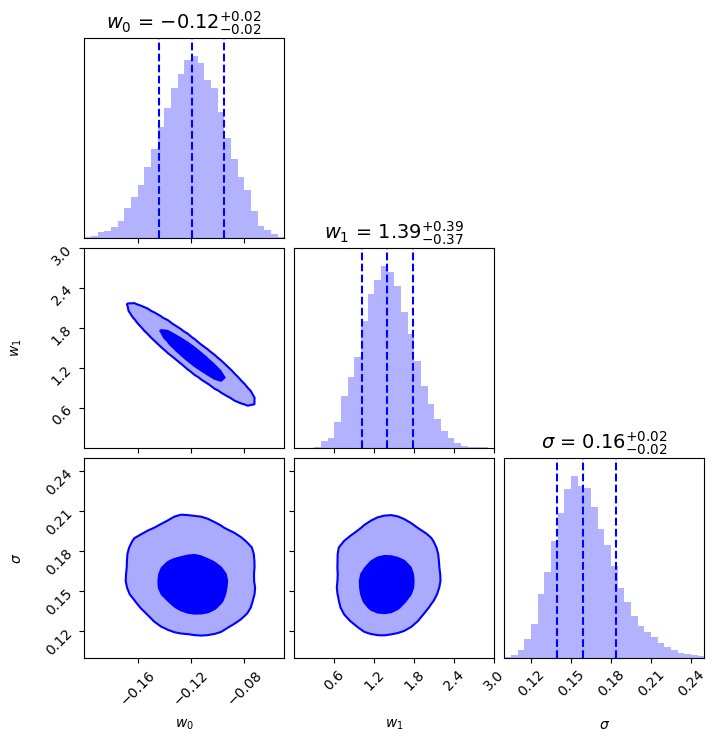

In [53]:
fig = corner.corner(mcmc_samples3.T, bins=30, smooth=1,
                    range=[[-0.2, -0.05], [0, 3], [0.1, 0.25]],   # Range for w0, w1, sigma. Adjust as needed.
                    labels=['$w_0$', '$w_1$', r'$\sigma$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Coma w/o dwarfs, 3rd iteration'},
                    title_kwargs={"fontsize": 14})

In [54]:
a3, b3, cov3 = param_invert(w0_3, w1_3, cov_w_3[:2,:2])

print(f'         w0: {w0_3:.3f} +/- {np.sqrt(cov_w_3[0,0]):.3f}')
print(f'         w1:  {w1_3:.2f}  +/- {np.sqrt(cov_w_3[1,1]):.2f}')
print(f'      slope: {a3:.2f}  +/- {np.sqrt(cov3[0,0]):.2f}')
print(f'y-intercept: {b3:.2f}  +/- {np.sqrt(cov3[1,1]):.2f}')

         w0: -0.119 +/- 0.024
         w1:  1.39  +/- 0.38
      slope: -8.39  +/- 2.15
y-intercept: 11.65  +/- 1.08


In [55]:
# Invert the MCMC samples so that they represent (a, b) and not (w0, w1)
tfr_mcmc_samples3 = np.zeros(mcmc_samples3.shape)

tfr_mcmc_samples3[0] = 1./mcmc_samples3[0]
tfr_mcmc_samples3[1] = -mcmc_samples3[1]/mcmc_samples3[0]
tfr_mcmc_samples3[2] = mcmc_samples3[2]

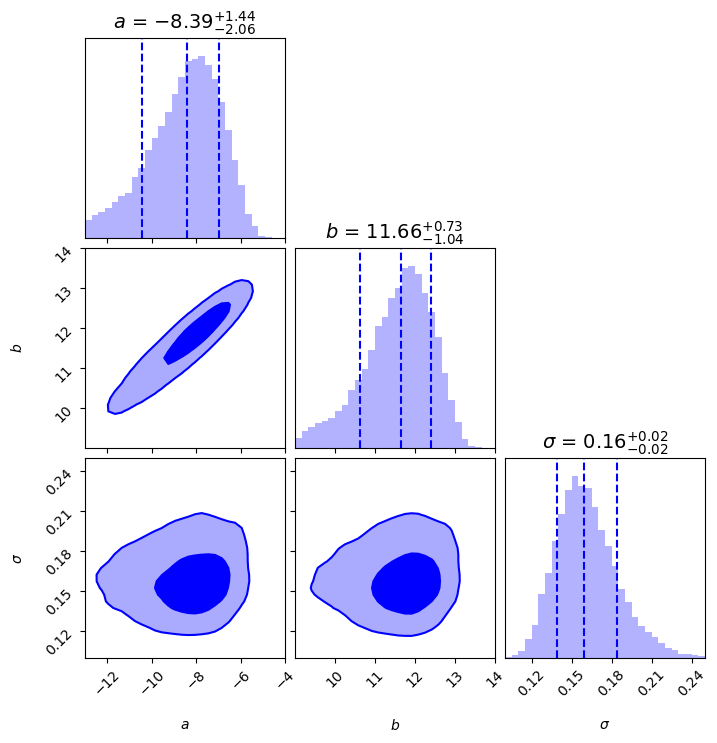

In [59]:
fig = corner.corner(tfr_mcmc_samples3.T, bins=30, smooth=1,
             range=[[-13, -4], [9, 14], [0.1, 0.25]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title = {'Coma w/o dwarfs, 3rd iteration'},
             title_kwargs={"fontsize": 14})

#fig.savefig('../../Figures/SV/fuji_Coma_corner_20221013.png', dpi=150)

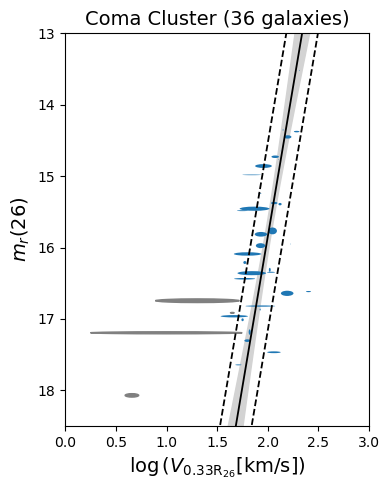

In [60]:
sigmas = hf3.get_sigmas()
xvals = np.linspace(1., 3., 1000)
yvals = a3 * (xvals - V0) + b3

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals - V0, tfr_mcmc_samples3[0]) + tfr_mcmc_samples3[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [np.log10(SGA_TF_bright3['V_0p33R26']), SGA_TF_bright3['R_MAG_SB26']]
x_err = 0.434*SGA_TF_bright3['V_0p33R26_err']/SGA_TF_bright3['V_0p33R26']
y_err = SGA_TF_bright3['R_MAG_SB26_ERR']
corr_xy = np.zeros_like(x_err)

# Removed galaxies
data_removed = [np.log10(SGA_TF['V_0p33R26'][dwarfs3]), SGA_TF['R_MAG_SB26'][dwarfs3]]
x_err_removed = 0.434*SGA_TF['V_0p33R26_err'][dwarfs3]/SGA_TF['V_0p33R26'][dwarfs3]
y_err_removed = SGA_TF['R_MAG_SB26_ERR'][dwarfs3]
corr_xy_removed = np.zeros_like(x_err_removed)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2*y_err[i],
        height=2*x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]
ells_removed = [
    Ellipse(
        xy=[data_removed[0][i], data_removed[1][i]],
        width=2*y_err_removed[i],
        height=2*x_err_removed[i],
        angle=np.rad2deg(np.arccos(corr_xy_removed[i])),
    )
    for i in range(len(data_removed[0]))
]

# Make the plot
fig, ax = plt.subplots(figsize=(4,5), tight_layout=True)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="lightgray")
for i, e in enumerate(ells):
    ax.add_artist(e)
    e.set_edgecolor('None')
for i, e in enumerate(ells_removed):
    ax.add_artist(e)
    e.set_color('gray')
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3)#, alpha=0.9)
ax.plot(xvals - hf3.vert_scat, yvals, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.plot(xvals + hf3.vert_scat, yvals, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$m_r(26)$", fontsize=14)
ax.set_title("Coma Cluster ({} galaxies)".format(len(SGA_TF_bright2)), fontsize = 14)
ax.set_xlim(0, 3)
ax.set_ylim(18.5, 13);

#plt.savefig('../../Figures/SV/fuji_Coma_TFR_20221013.png', dpi=150)

### Fourth iteration

Using `dwarfs4` sample

In [43]:
w0_4, w1_4, sig_w_4, cov_w_4, mcmc_samples4, hf4 = hyperfit_line(SGA_TF_bright4['R_MAG_SB26'], 
                                                                 np.log10(SGA_TF_bright4['V_0p33R26']) - V0, 
                                                                 SGA_TF_bright4['R_MAG_SB26_ERR'], 
                                                                 0.434*SGA_TF_bright4['V_0p33R26_err']/SGA_TF_bright4['V_0p33R26'], 
                                                                 bounds)

     fun: -46.9829803213327
     jac: array([2.41584530e-05, 5.89750474e-05, 1.61719527e-03])
 message: 'Optimization terminated successfully.'
    nfev: 6766
     nit: 149
 success: True
       x: array([0.16646637, 1.38069271, 0.15339897])


100%|██████████| 1000/1000 [00:00<00:00, 2096.91it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [54.89615104 55.56378926 42.85509399] / 2778.18946308636


100%|██████████| 1000/1000 [00:00<00:00, 2102.04it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [81.61842571 81.79127782 55.77752547] / 4089.5638910777025


100%|██████████| 1000/1000 [00:00<00:00, 2091.94it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 99.4602417  101.11358347  57.17641382] / 5055.679173489147


100%|██████████| 1000/1000 [00:00<00:00, 2112.01it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [160.38674795 162.79190695  61.58762476] / 8139.595347745186


100%|██████████| 1000/1000 [00:00<00:00, 2102.27it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [170.47120063 174.2313415   63.10165358] / 8711.56707504017


100%|██████████| 1000/1000 [00:00<00:00, 2103.59it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [181.28888827 186.39096596  68.77356329] / 9319.548298214419


100%|██████████| 1000/1000 [00:00<00:00, 2111.04it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [189.68163809 195.97883257  68.27818023] / 9798.941628366807


100%|██████████| 1000/1000 [00:00<00:00, 2124.71it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [194.81745078 197.58951711  74.33326853] / 9879.475855628349


100%|██████████| 1000/1000 [00:00<00:00, 2100.75it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [192.62885917 196.24944095  74.04031734] / 9812.472047294434


100%|██████████| 1000/1000 [00:00<00:00, 2105.25it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [221.29014951 222.31462507  78.57792229] / 11115.731253740234


100%|██████████| 1000/1000 [00:00<00:00, 2134.20it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [277.32660738 277.15936277  79.17068054] / 13866.330369144613


100%|██████████| 1000/1000 [00:00<00:00, 2110.79it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [291.46311532 294.39912968  84.58093743] / 14719.956483840539


100%|██████████| 1000/1000 [00:00<00:00, 2101.48it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [293.70266699 305.81835381  85.30862984] / 15290.91769039328


100%|██████████| 1000/1000 [00:00<00:00, 2134.18it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [275.93743933 286.50890713  86.22130345] / 14325.44535658756


100%|██████████| 1000/1000 [00:00<00:00, 2109.07it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [287.9819954 294.4700018  83.621756 ] / 14723.500090036814


100%|██████████| 1000/1000 [00:00<00:00, 2125.32it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [276.23201248 285.62779462  88.58278549] / 14281.389731173931


100%|██████████| 1000/1000 [00:00<00:00, 2137.36it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [230.71585108 240.77073453  85.78525458] / 12038.536726468605


100%|██████████| 1000/1000 [00:00<00:00, 2160.54it/s]


Niterations/Max Iterations:  18000 / 100000
Integrated ACT/Min Convergence Iterations:  [294.8771161  298.91024494 105.43968645] / 14945.512246844413


100%|██████████| 1000/1000 [00:00<00:00, 2167.14it/s]


Niterations/Max Iterations:  19000 / 100000
Integrated ACT/Min Convergence Iterations:  [337.88368874 340.98897158 115.10647316] / 17049.448578876367


100%|██████████| 1000/1000 [00:00<00:00, 2169.68it/s]


Niterations/Max Iterations:  20000 / 100000
Integrated ACT/Min Convergence Iterations:  [375.60780598 385.01772208 112.25800777] / 19250.886104052308


100%|██████████| 1000/1000 [00:00<00:00, 2103.23it/s]


Niterations/Max Iterations:  21000 / 100000
Integrated ACT/Min Convergence Iterations:  [361.20957544 370.83048293 115.33816187] / 18541.52414628705


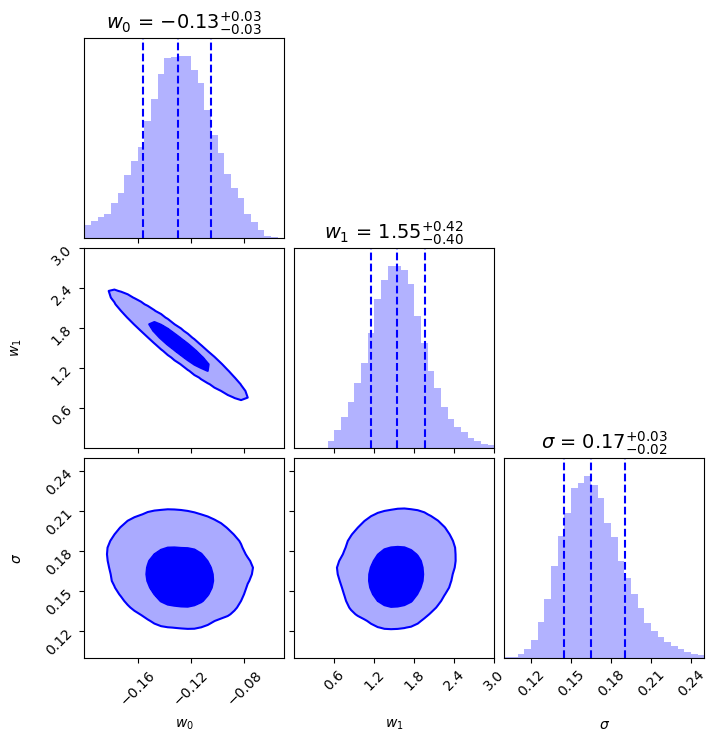

In [44]:
fig = corner.corner(mcmc_samples4.T, bins=30, smooth=1,
                    range=[[-0.2, -0.05], [0, 3], [0.1, 0.25]],   # Range for w0, w1, sigma. Adjust as needed.
                    labels=['$w_0$', '$w_1$', r'$\sigma$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Coma w/o dwarfs, 4th iteration'},
                    title_kwargs={"fontsize": 14})

In [45]:
a4, b4, cov4 = param_invert(w0_4, w1_4, cov_w_4[:2,:2])

print(f'         w0: {w0_4:.3f} +/- {np.sqrt(cov_w_4[0,0]):.3f}')
print(f'         w1:  {w1_4:.2f}  +/- {np.sqrt(cov_w_4[1,1]):.2f}')
print(f'      slope: {a4:.2f}  +/- {np.sqrt(cov4[0,0]):.2f}')
print(f'y-intercept: {b4:.2f}  +/- {np.sqrt(cov4[1,1]):.2f}')

         w0: -0.130 +/- 0.027
         w1:  1.55  +/- 0.42
      slope: -7.71  +/- 2.02
y-intercept: 11.91  +/- 1.03


In [47]:
# Invert the MCMC samples so that they represent (a, b) and not (w0, w1)
tfr_mcmc_samples4 = np.zeros(mcmc_samples4.shape)

tfr_mcmc_samples4[0] = 1./mcmc_samples4[0]
tfr_mcmc_samples4[1] = -mcmc_samples4[1]/mcmc_samples4[0]
tfr_mcmc_samples4[2] = mcmc_samples4[2]

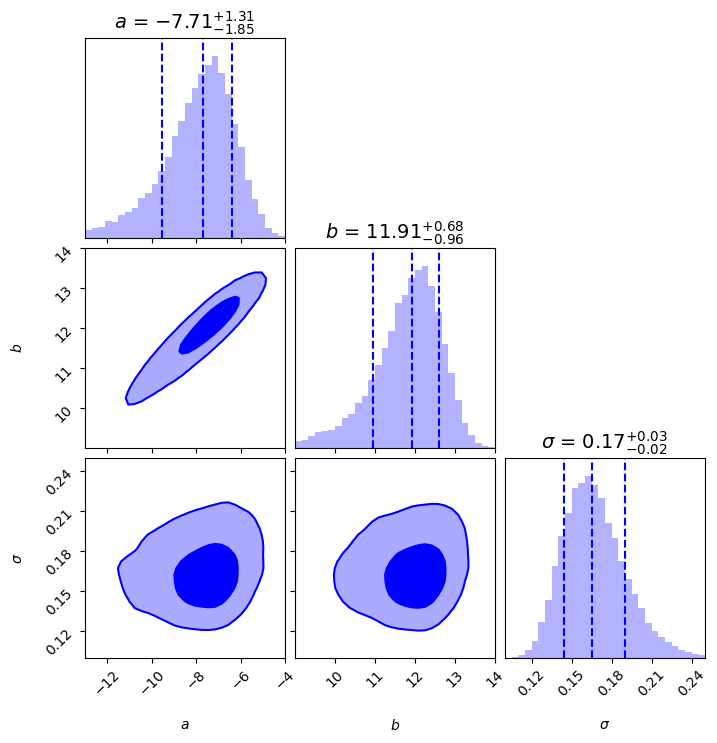

In [48]:
fig = corner.corner(tfr_mcmc_samples4.T, bins=30, smooth=1,
             range=[[-13, -4], [9, 14], [0.1, 0.25]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title = {'Coma w/o dwarfs, 4th iteration'},
             title_kwargs={"fontsize": 14})

#fig.savefig('../../Figures/SV/fuji_Coma_corner_20221013.png', dpi=150)

### Fifth iteration

Using `dwarfs5` sample

#### Create covariance matrix for `hyperfit`

In [103]:
Ndata = len(SGA_TF_bright5)
cov = np.empty((2, 2, Ndata))

# loop over arrays of uncertainties in logv and mag
# Assume diagonal covariance for each measurement.
for i in range(Ndata):
    cov[:,:,i] = np.array([[(0.434*SGA_TF_bright5['V_0p33R26_err'][i]/SGA_TF_bright5['V_0p33R26'][i])**2, 0.], 
                           [0., SGA_TF_bright5['R_MAG_SB26_ERR'][i]**2]])

#### Create `hyperfit` object

In [104]:
hf = LinFit([np.log10(SGA_TF_bright5['V_0p33R26']) - 2., SGA_TF_bright5['R_MAG_SB26']], cov)

#### Run MCMC to fit TFR

In [105]:
bounds5 = ((-10.0, 10.0), (-1000.0, 1000.0), (1.0e-5, 500.0))

mcmc_samples5, mcmc_lnlike5 = hf.emcee(bounds5, verbose=True)

print(np.mean(mcmc_samples5, axis=1), np.std(mcmc_samples5, axis=1))

     fun: -48.68105983796883
     jac: array([ 0.00243858,  0.0049468 , -0.00932729])
 message: 'Optimization terminated successfully.'
    nfev: 7040
     nit: 155
 success: True
       x: array([1.5517684 , 0.1503824 , 0.13236643])


100%|██████████| 1000/1000 [00:00<00:00, 2285.22it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [64.31885899 64.59977796 45.57150876] / 3229.988898242772


100%|██████████| 1000/1000 [00:00<00:00, 2199.47it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [110.86030481 110.71432671  53.75784727] / 5543.0152407348305


100%|██████████| 1000/1000 [00:00<00:00, 2301.37it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [149.75172659 145.96174543  52.3873728 ] / 7487.5863292956765


100%|██████████| 1000/1000 [00:00<00:00, 2203.46it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [156.71015617 156.50587747  60.11999205] / 7835.507808636918


100%|██████████| 1000/1000 [00:00<00:00, 2349.13it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [182.21271785 179.59944327  64.71414446] / 9110.635892690509


100%|██████████| 1000/1000 [00:00<00:00, 2230.75it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [195.08892902 191.15233048  68.59877375] / 9754.44645093459


100%|██████████| 1000/1000 [00:00<00:00, 2269.60it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [173.28945113 174.59022251  63.56440374] / 8729.511125391793


100%|██████████| 1000/1000 [00:00<00:00, 2179.16it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [229.50231831 228.18389845  66.87361421] / 11475.115915346169


100%|██████████| 1000/1000 [00:00<00:00, 2219.40it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [217.50653647 215.71407385  65.71647347] / 10875.326823540241


100%|██████████| 1000/1000 [00:00<00:00, 2317.25it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [263.15422925 255.5412686   66.30916608] / 13157.711462743031


100%|██████████| 1000/1000 [00:00<00:00, 2148.58it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [281.2414003  273.71332018  65.69520555] / 14062.070014865447


100%|██████████| 1000/1000 [00:00<00:00, 2174.32it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [286.55393768 280.30472568  68.8496102 ] / 14327.696883963261


100%|██████████| 1000/1000 [00:00<00:00, 2246.23it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [273.43631091 265.30683448  64.83661488] / 13671.815545261783


100%|██████████| 1000/1000 [00:00<00:00, 2234.31it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [253.04379252 248.33811786  66.79385299] / 12652.189626087258


100%|██████████| 1000/1000 [00:00<00:00, 2137.61it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [240.70829715 232.88105289  66.11153072] / 12035.414857543921


100%|██████████| 1000/1000 [00:00<00:00, 2177.60it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [235.91006904 227.9287405   67.4460321 ] / 11795.503451821307
[-10.25240964  16.15874964   1.47558952] [2.82324216 0.32166154 0.47033494]


#### Plot the Hyperfit

After the linear fit MCMC, construct the bestfit line and its 1-sigma uncertainties.

Also plot the measurements as ellipses with the size given by the uncertainties in log(v) and $m_r$, and the color given by the best-fit scatter parameter $\sigma_i$.

Code taken from plotting examples in [hyperfit documentation](https://hyperfit.readthedocs.io/en/latest/tutorial.html#a-simple-best-fit).

In [106]:
a5, b5, sig5    = np.median(mcmc_samples5, axis=1)
da5, db5, dsig5 = np.std(mcmc_samples5, axis=1)

for val, err in zip((a5, b5, sig5), (da5, db5, dsig5)):
    print('{:6.2f} +/- {:.2f}'.format(val, err))

 -9.68 +/- 2.82
 16.13 +/- 0.32
  1.37 +/- 0.47


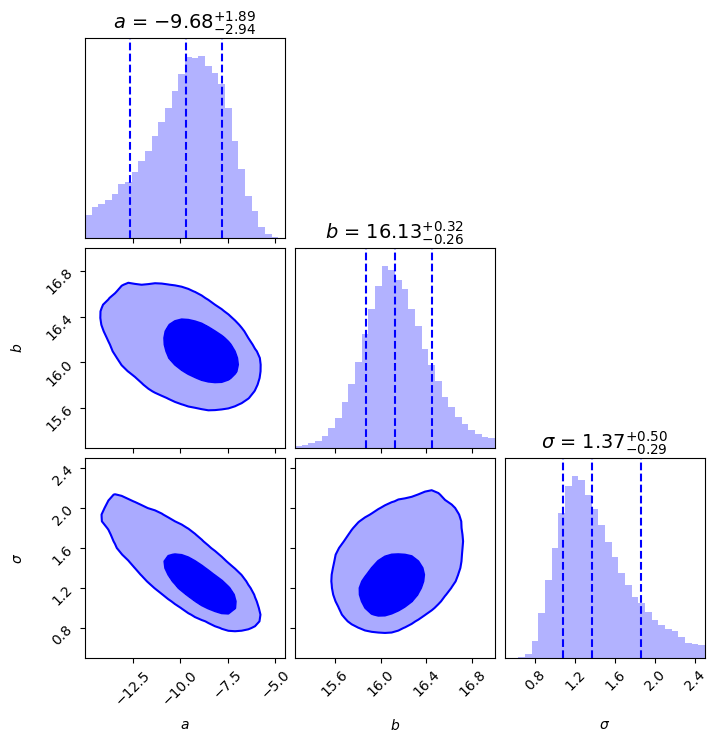

In [110]:
fig = corner.corner(mcmc_samples5.T, bins=30, smooth=1,
             range=[[-15, -4.5], [15.25, 17], [0.5, 2.5]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title = {'Coma'},
             title_kwargs={"fontsize": 14})

#fig.savefig('../../Figures/SV/fuji_Coma_corner_20221013.png', dpi=150)